# Movielens Dataset Temporal Analysis 

In [1]:
# Center All Plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Load Libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from timeit import default_timer  # Time the actions we take
from collections import deque     # To shift lists
import os 

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Load Data

In [12]:
class NetflixDataset:
    
    def __init__(self, ratings_col_names=('user_id', 'rating', 'timestamp'),
                       ratings_path=r'C:\Users\Yukawa\datasets\netflix\combined_data_1.txt',
                       movies_col_names=('item_id', 'year', 'title'),
                       movies_path=r'C:\Users\Yukawa\datasets\netflix\movie_titles.csv',
                       is_ratings_cached=True, is_movies_cached=True):
        self.is_ratings_cached = is_ratings_cached
        self.is_movies_cached = is_movies_cached
        self.ratings = NetflixDataset.load_ratings(ratings_path, 
                                                   ratings_col_names) if self.is_ratings_cached else None
        self.movies = NetflixDataset.load_movies(movies_path,
                                                   movies_col_names) if self.is_movies_cached else None
        
    @staticmethod
    def load_movies(movies_path,
                    movies_col_names=('item_id', 'year', 'title')):
        movies = pd.read_csv(movies_path, encoding='ISO-8859-1', header=None, names=movies_col_names)
        movies['year'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        movies['year'] = movies['year'].astype(int)
        movies = movies.reindex(columns=movies_col_names)
        
        # From the netflix prize dataset, I will only be using the first part which contains 4449 unique movies. 
        # That is why I will be truncating the other movies but if you load all the netflix data, remove this line.
        movies = movies[:4499]    # Keep only the first 4499 movies of the dataset
        
        return movies
    
    @staticmethod
    def load_ratings(ratings_path,
                     ratings_col_names=('user_id', 'rating', 'timestamp')):    
        if not os.path.isfile(ratings_path) or not ratings_col_names:
            return None
        
        ratings_raw = pd.read_csv(ratings_path, header=None, names=['user_id', 'rating', 'timestamp'], usecols=[0, 1, 2])
        ratings_raw['rating'] = ratings_raw['rating'].astype(float)
        # Find empty rows to slice dataframe for each movie
        temp_movies = ratings_raw[ratings_raw['rating'].isna()]['user_id'].reset_index()
        movie_indexes = [[index, int(movie[:-1])] for index, movie in temp_movies.values]

        # Shift the movie_indexes by one to get start and endpoints of all movies
        shifted_movie_indexes = deque(movie_indexes)
        shifted_movie_indexes.rotate(-1)

        # Gather all dataframes
        user_data = []
        for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indexes, shifted_movie_indexes):

            # if it is the last movie in the file
            if df_id_1 < df_id_2:
                temp_df = ratings_raw[(df_id_1+1):(df_id_2-1)].copy()
            else:
                temp_df = ratings_raw[df_id_1+1:].copy()

            # Create movie id column
            temp_df['item_id'] = movie_id

            # Append dataframe to list

            user_data.append(temp_df)

        # Combile all  dataframes
        ratings = pd.concat(user_data)
        del user_data, ratings_raw, temp_movies, temp_df, shifted_movie_indexes, movie_indexes, df_id_1, df_id_2, movie_id, next_movie_id
        
        # Convert the column order to the same order as the MovieLens dataset for ease of use
        ratings = ratings.reindex(columns=['user_id', 'item_id', 'rating', 'timestamp'])
        
        # Convert the string timestamps into datetime type
        ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], infer_datetime_format=True)
        
        # Convert the string user ids into int
        ratings['user_id'] = ratings['user_id'].astype(int)
        
        #### !!! Drop These three lines if No Memory and Time Constraint are set.
        netflix_users = NetflixDataset.get_filtered_netflix_users(ratings)
        ratings = ratings.loc[ (ratings['user_id'].isin(netflix_users)) ]
        ratings.reset_index(inplace=True, drop=True)
        
        return ratings
    
    @staticmethod
    def get_filtered_netflix_users(ratings):
        data = ratings
        active_users = pd.DataFrame(data.groupby('user_id')['rating'].mean())
        active_users['No_of_ratings'] = pd.DataFrame(data.groupby('user_id')['rating'].count())
        active_users.sort_values(by=['No_of_ratings'], ascending=False, inplace=True)
        active_users.columns = ['mean_rating', 'No_of_ratings']
        return active_users.loc[active_users['No_of_ratings'] > 40].drop_duplicates('mean_rating').drop_duplicates('No_of_ratings').index.values
    
    @staticmethod
    def load(ratings_col_names=('user_id', 'rating', 'timestamp'),
             ratings_path=r'C:\Users\Yukawa\datasets\netflix\combined_data_1.txt',
             movies_col_names=('item_id', 'year', 'title'),
             movies_path=r'C:\Users\Yukawa\datasets\netflix\movie_titles.csv'):
        
        # Load movies
        movies = NetflixDataset.load_movies(movies_path=movies_path, movies_col_names=movies_col_names)
        
        # Load Ratings
        ratings = NetflixDataset.load_ratings(ratings_path=ratings_path, ratings_col_names=ratings_col_names)
        
        # Merge the ratings and movies
        movie_ratings = NetflixDataset.create_movie_ratings(ratings, movies)
        
        return movie_ratings

## Configure

In [13]:
dataset = NetflixDataset( movies_col_names=('movieId', 'year', 'title') )

In [14]:
dataset.movies

,movieId,year,title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
4494,4495,2002,Clifford: Happy Birthday Clifford / Puppy Love
4495,4496,1993,Farewell My Concubine
4496,4497,1990,Texasville
4497,4498,2000,Gonin


In [15]:
# Load Dataset
movies = dataset.movies.loc[dataset.movies['year'] != 0]
movies.head(10)

,movieId,year,title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
5,6,1997,Sick
6,7,1992,8 Man
7,8,2004,What the #$*! Do We Know!?
8,9,1991,Class of Nuke 'Em High 2
9,10,2001,Fighter


In [16]:
dataset.ratings

,user_id,item_id,rating,timestamp
0,1227322,1,4.0,2004-02-06
1,525356,1,2.0,2004-07-11
2,1927580,1,4.0,2004-11-08
3,716874,1,5.0,2005-05-06
4,883478,1,4.0,2005-12-16
...,...,...,...,...
484801,387418,4499,2.0,2004-02-10
484802,1114324,4499,1.0,2005-10-13
484803,1932594,4499,1.0,2005-02-15
484804,811530,4499,4.0,2004-07-28


In [17]:
ratings = dataset.ratings.copy(deep=True)
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings.head(10)

,userId,movieId,rating,timestamp
0,1227322,1,4.0,2004-02-06
1,525356,1,2.0,2004-07-11
2,1927580,1,4.0,2004-11-08
3,716874,1,5.0,2005-05-06
4,883478,1,4.0,2005-12-16
5,1792741,1,2.0,2004-02-09
6,1719610,1,2.0,2005-08-19
7,636262,1,1.0,2005-09-26
8,2439493,1,1.0,2004-02-06
9,530789,1,5.0,2005-03-29


##  Explore The Movielens Dataset

### 0. Number of Ratings Per Year

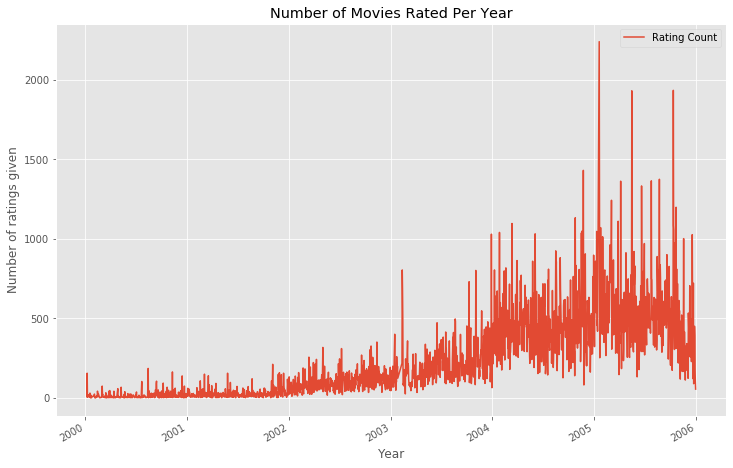

In [18]:
ratings_per_year = ratings[['rating', 'timestamp']].groupby('timestamp').count()
ratings_per_year.columns = ['Rating Count']
ax1 = ratings_per_year.plot(kind='line',figsize=(12,8))
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of ratings given')
plt.title('Number of Movies Rated Per Year')
plt.show()

### 1. Movies Released per Year

In [19]:
# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies.loc[movies['year'] != 0][['movieId', 'year']].groupby('year')
dftmp.head()

,movieId,year
0,1,2003
1,2,2004
2,3,1997
3,4,1994
4,5,2004
...,...,...
4187,4188,1917
4248,4249,1925
4252,4253,1949
4300,4301,1925


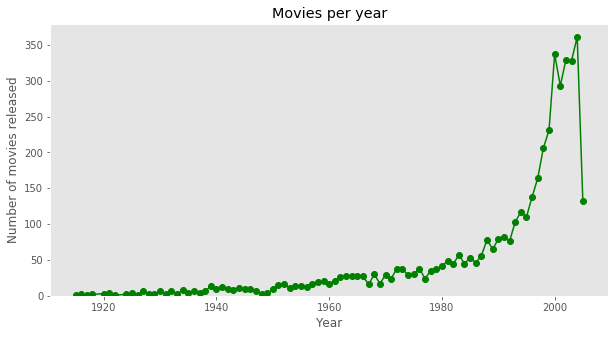

In [20]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$)

<font color=darkblue>**PLOT#1**: Cumulative number of movies, in total </font><br/>
<font color=green>**INSIGHT#1**: Most Movies are released in between 1980 and 2020</font>

### 2. Ratings per Year

In [21]:
dftmp = ratings[['rating', 'timestamp']].groupby('timestamp')
dftmp.head()

,rating,timestamp
0,4.0,2004-02-06
1,2.0,2004-07-11
2,4.0,2004-11-08
3,5.0,2005-05-06
4,4.0,2005-12-16
...,...,...
477051,3.0,2001-01-14
477130,2.0,2001-01-13
477387,3.0,2001-04-13
479301,2.0,2000-01-17


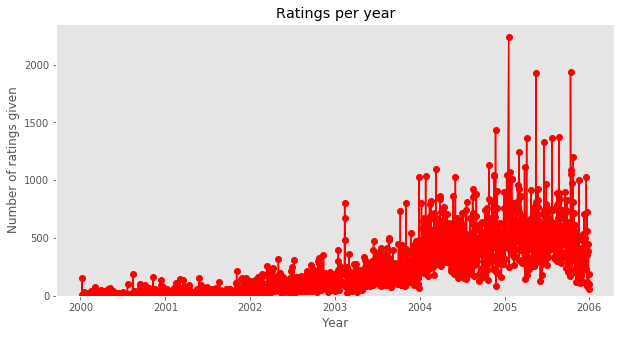

In [22]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax1.grid(None)
ax1.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of ratings given')
plt.title('Ratings per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$)

<font color=darkblue>**PLOT#2**: Number of Ratings Given Per Year </font><br/>
<font color=green>**INSIGHT#2**: Ratings given vary in different years.Most Ratings are given around year 2000</font>

### 3. Average Movie Rating

In [23]:
dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())
dftmp.head()

,year,rating
movieId,,
1,2003,3.240741
2,2004,1.937500
3,1997,2.871795
4,1994,2.000000
5,2004,2.547170


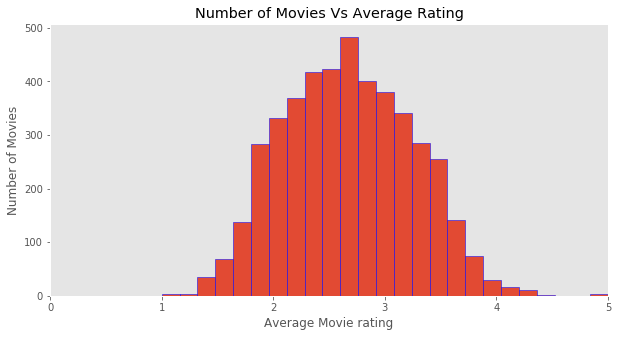

In [24]:
dftmp.rating.hist(bins=25, grid=False, edgecolor='b',figsize=(10,5))
plt.xlim(0,5)
plt.xlabel('Average Movie rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Vs Average Rating')
plt.show()
# Housekeeping
%reset_selective -f (^dftmp$)

<font color=darkblue>**PLOT#3**: Average Movie Ratings</font><br/>
<font color=green>**INSIGHT#3**: Average movie ratings creates normal distrubition peaked at about 3.5 </font>

### 4. Average Movie Ratings Per Year

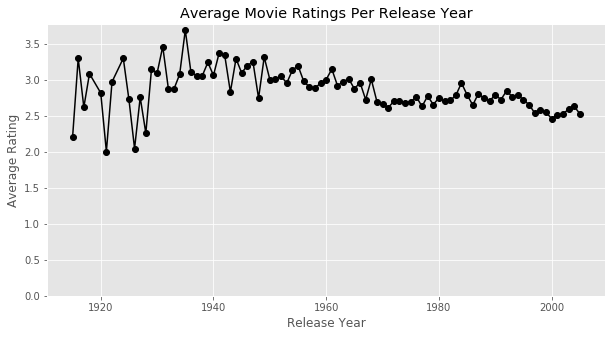

In [25]:
plt.figure(figsize=(10,5))

dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "r-o", label='All genres', color='black')

plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Ratings Per Release Year')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

<font color=darkblue>**PLOT#4**: Average Movie Ratings Per Year</font><br/>
<font color=green>**INSIGHT#4**: While movies released after 1960s have more stable average rating, old movies have huge variation in consecutive years </font>

### 5. Average Movie Ratings Per Year In Detail

In [26]:
first_rating_timestamp = ratings['timestamp'].min()
print("First Movie Released at",first_rating_timestamp)

First Movie Released at 2000-01-07 00:00:00


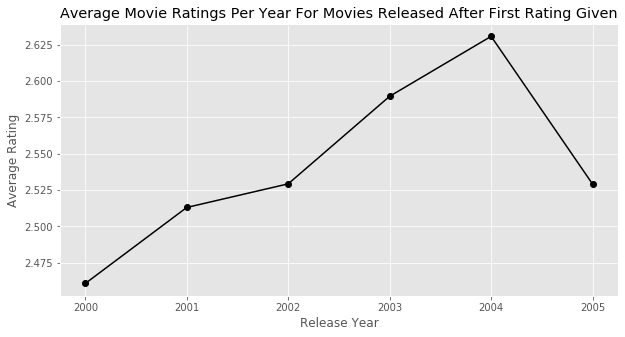

In [28]:
plt.figure(figsize=(10,5))

dftmp = movies[['movieId', 'year']].set_index('movieId')
dftmp = dftmp[dftmp['year'] >= first_rating_timestamp.year]
dftmp = dftmp.join(ratings[ratings.set_index('movieId').index.isin(dftmp.index)][['movieId', 'rating']]
                   .groupby('movieId').mean())
dftmp = dftmp.groupby('year').mean()
plt.plot(dftmp, "r-o", label='All genres', color='black')

plt.xlabel('Release Year')
plt.ylabel('Average Rating')
plt.title('Average Movie Ratings Per Year For Movies Released After First Rating Given')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^genre$)

<font color=darkblue>**PLOT#5**: Average Rating For Movies Released After First Rating Given</font><br/>
<font color=green>**INSIGHT#5**: Users bias changes in different years, as we can see in 2010 users gave average of 3.35 to movies and about 2.5 in 2015 </font><br/>
<font color=green>**INSIGHT#5.1**: When we take a closer look at the average rating of the movies that has been released after first rating given in the dataset, average ratings seem to change a lot as the years pass by. And, average ratings tend to go down. This raises questions like, does the movies released in adjacent years changes a lot, or the users having a different trend after the first trend and new movies that has been released on the adjacent years tend to be similar with old trend, which results in lower averages. </font>

### 6. Average Rating Per User

In [29]:
dftmp = ratings[['userId','rating']].groupby('userId').mean()
dftmp.head()

,rating
userId,
1333,2.676000
1427,3.619792
3321,2.559322
3458,3.233161
3604,3.416404


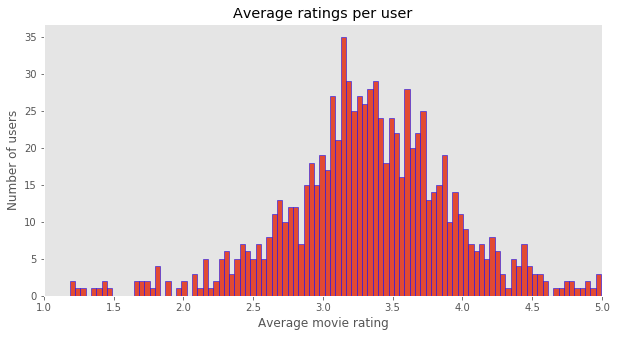

In [30]:
# Plot histogram
dftmp.rating.hist(bins=100, grid=False, edgecolor='b',figsize=(10,5))

plt.xlim(1,5)
plt.xlabel ('Average movie rating')
plt.ylabel ('Number of users')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

<font color=darkblue>**PLOT#6**: Average Rating Per User</font><br/>
<font color=green>**INSIGHT#6**: Users on average gives 3.7 to movies but different users have different average which shows us some of the users are inclined to give low rating and some of them inclined to give high ratings. </font>

### 7. Ratings Per User

In [31]:
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
dftmp.sort_values(by='num_ratings', inplace=True, ascending=False)
dftmp.head(10)

,num_ratings
userId,
305344,4467
387418,4422
2439493,4195
1664010,4019
2118461,3769
1639792,2500
1314869,2467
1461435,2449
1932594,2263


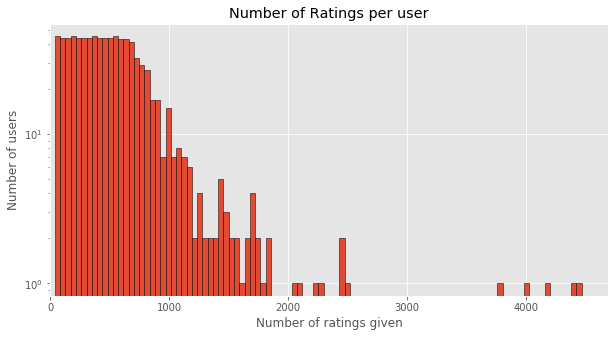

In [32]:
# Histogram of ratings counts.
plt.figure(figsize=(10,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Number of Ratings per user')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of users')
plt.xlim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

<font color=darkblue>**PLOT#7**: Number of Ratings Given Per User</font><br/>
<font color=green>**INSIGHT#7**: while high active users are tend to rate 200-500 movies, most of the users gave only few ratings almost 0. Dataset is quite sparse.  </font>

### 8. Rating Per Movie

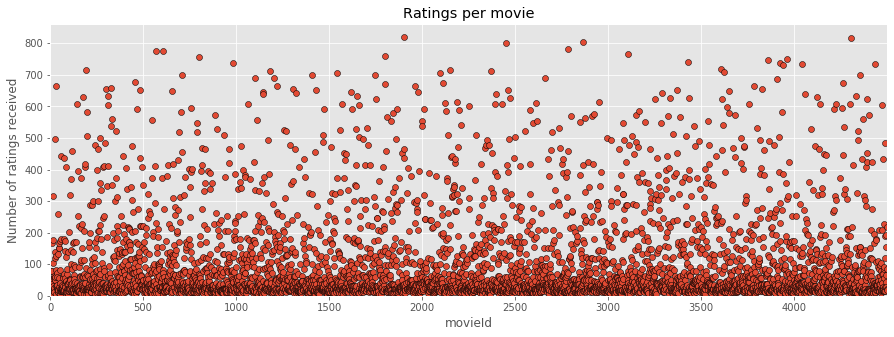

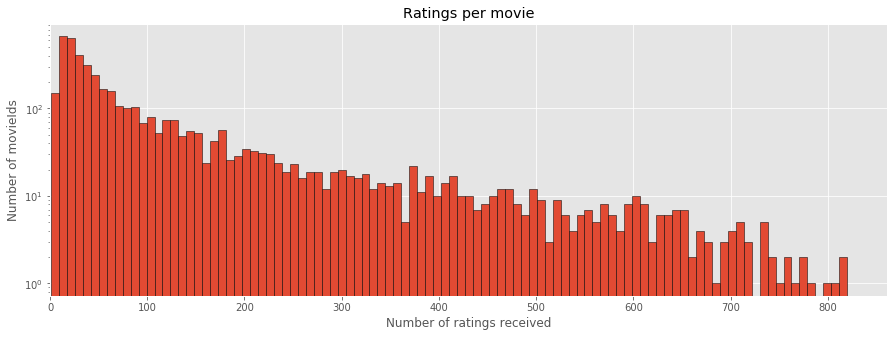

In [33]:
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

<font color=darkblue>**PLOT#7**: Number of Ratings Received Per Movie</font><br/>
<font color=green>**INSIGHT#7**: Almost %99 percent of the movies taken less than 150 ratings.  </font>

In [34]:
# Let's check those movies with +150 reviews, those should be pretty popular movies!
movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>150]]['title']

movieId
8       What the #$*! Do We Know!?
16                       Screamers
18                Immortal Beloved
28                 Lilo and Stitch
30          Something's Gotta Give
                   ...            
4488                   Wonder Boys
4490                     Ned Kelly
4492                    Club Dread
4493             Ju-on: The Grudge
4496         Farewell My Concubine
Name: title, Length: 980, dtype: object

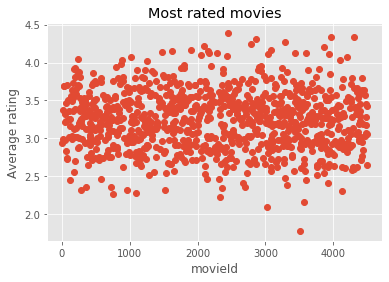

In [35]:
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>150]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most rated movies')
plt.show()

<font color=darkblue>**PLOT#8**: Most Rated Movies</font><br/>
<font color=green>**INSIGHT#8**: Most rated movies also tend to be most liked movies.  </font>

In [36]:
# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>100]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)

Best most popular movie ever is...Lord of the Rings: The Fellowship of the Ring


In [37]:
# Housekeeping
%reset_selective -f (^dftmp$|^tmp$|^best$|^copy_movies$)